In [2]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 1s 12us/step


In [5]:
train_data

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, ..., 1.47000e+01,
        3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.75520e+02, 3.26000e+00],
       ...,
       [3.46600e-02, 3.50000e+01, 6.06000e+00, ..., 1.69000e+01,
        3.62250e+02, 7.83000e+00],
       [2.14918e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.61950e+02, 1.57900e+01],
       [1.43900e-02, 6.00000e+01, 2.93000e+00, ..., 1.56000e+01,
        3.76700e+02, 4.38000e+00]])

In [6]:
# standardize (data has different ranges)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test_data)

In [7]:
from keras import models
from keras.layers import Dense

def build_model():
    model = models.Sequential()
    model.add(Dense(64, activation="relu", input_shape=(train_data.shape[1],)))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
    
    model.compile(optimizer="rmsprop",
                  loss="mse",
                  metrics=["mae"])
    return model

# mse is a common loss function to apply when the output is a number,
# in this case, the price of houses

In [15]:
# k-vold validation

import numpy as np

k = 4
num_val_samples = len(train_data) // k # identify indices to split data
num_epochs = 100
all_scores = []

# same as sklearn.preprocessing.KFold (no shuffle, shuffle → StratifiedKFold)
for i in range(k):
    print('processing fold #', i)
    # validation sets
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # training sets
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis = 0)
    
    # fit model
    model = build_model()
    model.fit(partial_train_data,
              partial_train_targets,
              epochs=num_epochs,
              batch_size=1,
              verbose=0) # verbose: 0 → silent; 1 → progress bar; 2 → one line per epoch
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [17]:
all_scores

[1.9876580238342285, 2.3105742931365967, 2.591171979904175, 2.445566415786743]

In [18]:
np.mean(all_scores)

2.333742678165436

In [19]:
# tuning number of epochs
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, 
                        partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, 
                        batch_size=1, 
                        verbose=0)
    
    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [20]:
average_mae_history = [
        np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

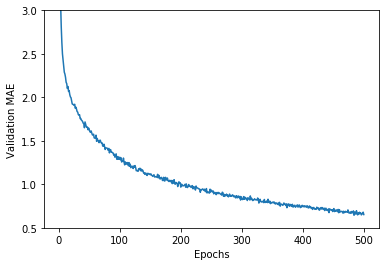

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.ylim(0.5,3)
plt.show()

In [23]:
model = build_model()
model.fit(train_data, 
          train_targets,
          epochs=500, 
          batch_size=16, 
          verbose=1)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

Epoch 1/500
404/404 [==============================] - 0s 617us/step - loss: 454.0858 - mae: 19.2774
Epoch 2/500
404/404 [==============================] - 0s 157us/step - loss: 247.1613 - mae: 13.5181
Epoch 3/500
404/404 [==============================] - 0s 128us/step - loss: 109.9672 - mae: 8.2202
Epoch 4/500
404/404 [==============================] - 0s 155us/step - loss: 59.2033 - mae: 5.8054
Epoch 5/500
404/404 [==============================] - 0s 133us/step - loss: 39.7384 - mae: 4.6202
Epoch 6/500
404/404 [==============================] - 0s 133us/step - loss: 29.3484 - mae: 3.8756
Epoch 7/500
404/404 [==============================] - 0s 143us/step - loss: 24.1273 - mae: 3.4746
Epoch 8/500
404/404 [==============================] - 0s 133us/step - loss: 21.0096 - mae: 3.2591
Epoch 9/500
404/404 [==============================] - 0s 116us/step - loss: 18.8037 - mae: 3.0310
Epoch 10/500
404/404 [==============================] - 0s 143us/step - loss: 17.1257 - mae: 2.8875
Epoc

404/404 [==============================] - 0s 187us/step - loss: 5.3817 - mae: 1.5811
Epoch 84/500
404/404 [==============================] - 0s 149us/step - loss: 5.0739 - mae: 1.5633
Epoch 85/500
404/404 [==============================] - 0s 164us/step - loss: 5.1061 - mae: 1.5922
Epoch 86/500
404/404 [==============================] - 0s 172us/step - loss: 5.1841 - mae: 1.5822
Epoch 87/500
404/404 [==============================] - 0s 165us/step - loss: 5.1025 - mae: 1.5529
Epoch 88/500
404/404 [==============================] - 0s 160us/step - loss: 5.0822 - mae: 1.5709
Epoch 89/500
404/404 [==============================] - 0s 200us/step - loss: 5.0281 - mae: 1.5354
Epoch 90/500
404/404 [==============================] - 0s 194us/step - loss: 5.0878 - mae: 1.5699
Epoch 91/500
404/404 [==============================] - 0s 165us/step - loss: 5.0671 - mae: 1.5406
Epoch 92/500
404/404 [==============================] - 0s 195us/step - loss: 4.9326 - mae: 1.5600
Epoch 93/500
404/404 [=

404/404 [==============================] - 0s 248us/step - loss: 2.9620 - mae: 1.2067
Epoch 165/500
404/404 [==============================] - 0s 175us/step - loss: 3.0349 - mae: 1.2282
Epoch 166/500
404/404 [==============================] - 0s 175us/step - loss: 2.9723 - mae: 1.2012
Epoch 167/500
404/404 [==============================] - 0s 176us/step - loss: 2.8612 - mae: 1.1821
Epoch 168/500
404/404 [==============================] - 0s 168us/step - loss: 3.1083 - mae: 1.2013
Epoch 169/500
404/404 [==============================] - 0s 164us/step - loss: 2.8459 - mae: 1.2001
Epoch 170/500
404/404 [==============================] - 0s 188us/step - loss: 2.8502 - mae: 1.1948
Epoch 171/500
404/404 [==============================] - 0s 170us/step - loss: 2.9133 - mae: 1.2070
Epoch 172/500
404/404 [==============================] - 0s 156us/step - loss: 2.8588 - mae: 1.1984
Epoch 173/500
404/404 [==============================] - 0s 244us/step - loss: 2.8906 - mae: 1.2031
Epoch 174/500


404/404 [==============================] - 0s 167us/step - loss: 2.0733 - mae: 1.0086
Epoch 246/500
404/404 [==============================] - 0s 153us/step - loss: 1.8957 - mae: 0.9795
Epoch 247/500
404/404 [==============================] - 0s 170us/step - loss: 1.9547 - mae: 1.0060
Epoch 248/500
404/404 [==============================] - 0s 163us/step - loss: 1.8516 - mae: 0.9570
Epoch 249/500
404/404 [==============================] - 0s 165us/step - loss: 2.0127 - mae: 1.0024
Epoch 250/500
404/404 [==============================] - 0s 256us/step - loss: 2.0410 - mae: 1.0333
Epoch 251/500
404/404 [==============================] - 0s 169us/step - loss: 2.0787 - mae: 1.0122
Epoch 252/500
404/404 [==============================] - 0s 165us/step - loss: 1.8884 - mae: 1.0009
Epoch 253/500
404/404 [==============================] - 0s 173us/step - loss: 1.8307 - mae: 0.9719
Epoch 254/500
404/404 [==============================] - 0s 173us/step - loss: 1.8692 - mae: 0.9831
Epoch 255/500


404/404 [==============================] - 0s 163us/step - loss: 1.2433 - mae: 0.8165
Epoch 327/500
404/404 [==============================] - 0s 188us/step - loss: 1.4468 - mae: 0.8792
Epoch 328/500
404/404 [==============================] - 0s 231us/step - loss: 1.3706 - mae: 0.8691
Epoch 329/500
404/404 [==============================] - 0s 128us/step - loss: 1.3876 - mae: 0.8627
Epoch 330/500
404/404 [==============================] - 0s 183us/step - loss: 1.5322 - mae: 0.9108
Epoch 331/500
404/404 [==============================] - 0s 173us/step - loss: 1.3849 - mae: 0.8606
Epoch 332/500
404/404 [==============================] - 0s 175us/step - loss: 1.4033 - mae: 0.8748
Epoch 333/500
404/404 [==============================] - 0s 174us/step - loss: 1.4651 - mae: 0.9096
Epoch 334/500
404/404 [==============================] - 0s 165us/step - loss: 1.3476 - mae: 0.8366
Epoch 335/500
404/404 [==============================] - 0s 168us/step - loss: 1.4107 - mae: 0.8834
Epoch 336/500


404/404 [==============================] - 0s 125us/step - loss: 1.0215 - mae: 0.7440
Epoch 409/500
404/404 [==============================] - 0s 146us/step - loss: 1.0640 - mae: 0.7659
Epoch 410/500
404/404 [==============================] - 0s 168us/step - loss: 1.1416 - mae: 0.7958
Epoch 411/500
404/404 [==============================] - 0s 145us/step - loss: 1.1184 - mae: 0.8008
Epoch 412/500
404/404 [==============================] - 0s 156us/step - loss: 1.1245 - mae: 0.7983
Epoch 413/500
404/404 [==============================] - 0s 210us/step - loss: 0.9521 - mae: 0.7329
Epoch 414/500
404/404 [==============================] - 0s 191us/step - loss: 1.0697 - mae: 0.7868
Epoch 415/500
404/404 [==============================] - 0s 188us/step - loss: 1.1650 - mae: 0.7756
Epoch 416/500
404/404 [==============================] - 0s 156us/step - loss: 1.0515 - mae: 0.7465
Epoch 417/500
404/404 [==============================] - 0s 158us/step - loss: 0.9890 - mae: 0.7434
Epoch 418/500


404/404 [==============================] - 0s 160us/step - loss: 0.8205 - mae: 0.6789
Epoch 491/500
404/404 [==============================] - 0s 158us/step - loss: 0.9224 - mae: 0.7102
Epoch 492/500
404/404 [==============================] - 0s 173us/step - loss: 0.9024 - mae: 0.6984
Epoch 493/500
404/404 [==============================] - 0s 170us/step - loss: 0.8758 - mae: 0.6540
Epoch 494/500
404/404 [==============================] - 0s 168us/step - loss: 0.7925 - mae: 0.6646
Epoch 495/500
404/404 [==============================] - 0s 176us/step - loss: 0.8482 - mae: 0.6661
Epoch 496/500
404/404 [==============================] - 0s 172us/step - loss: 0.7448 - mae: 0.6684
Epoch 497/500
404/404 [==============================] - 0s 173us/step - loss: 0.9379 - mae: 0.7211
Epoch 498/500
404/404 [==============================] - 0s 185us/step - loss: 0.7867 - mae: 0.6423
Epoch 499/500
404/404 [==============================] - 0s 165us/step - loss: 0.8474 - mae: 0.6703
Epoch 500/500


3.0848495960235596